<h1>Machine Learning for Data Analysis</h1>
<i><h2>Week 4 - K-Means Cluster Analaysis</h2></i>

The data set I am using is the Gapminder data set. A series of observational variables that have independent sources that have been centralised into one set.

I am investigating the association between incomeperperson and armedforcesrate. The association, or hypothesis, I am expecting is for higher incomeperperson there will be a lower armedforcesrate. So my coefficient to my explanetory variable should be less than 0. I will also be looking at the type of government, the polityscore variable, and seeing if that has a confounding effect.

For the k-means cluster analysis I will be using the explanetory variables incomeperperson, polityscore, lifeexpectancy, alcconsumption, co2emissions, urbanrate (which were identified by the LASSO regression analysis last week) and the reponse variable armedforcesrate to try and identify associated clusters in polityscore. I will use country to act as a unique identifier for each observation.

<h3>SET UP</h3>

<i>Import appropraite packages and set appropriate options</i>

In [1]:
#Data structures and data types
import pandas as pd
import numpy as np
#Modelling
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
#Graph
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
%matplotlib inline

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', None)

<i>Read in the data set</i>

In [3]:
usecols = ['incomeperperson', 'armedforcesrate', 'polityscore', 'country', \
           'lifeexpectancy', 'alcconsumption','co2emissions', 'urbanrate']
gap_data = pd.read_csv('gapminder.csv', usecols = usecols, index_col='country')

<i>Replace spaces with blanks and coerce into numeric, replacing the spaces with an empty string is needed for converting to numeric</i>

In [4]:
gap_data.loc[:,'incomeperperson'] = pd.to_numeric(gap_data['incomeperperson'].replace(' ',''))
gap_data.loc[:,'armedforcesrate'] = pd.to_numeric(gap_data['armedforcesrate'].replace(' ',''))
gap_data.loc[:,'polityscore'] = pd.to_numeric(gap_data['polityscore'].replace(' ',''))
gap_data.loc[:,'lifeexpectancy'] = pd.to_numeric(gap_data['lifeexpectancy'].replace(' ',''))
gap_data.loc[:,'alcconsumption'] = pd.to_numeric(gap_data['alcconsumption'].replace(' ',''))
gap_data.loc[:,'co2emissions'] = pd.to_numeric(gap_data['co2emissions'].replace(' ',''))
gap_data.loc[:,'urbanrate'] = pd.to_numeric(gap_data['urbanrate'].replace(' ',''))

<i>Remove any rows where there are nulls</i>

In [5]:
gap_data.dropna(inplace = True)

<i>Convert the polityscore variable to integer</i>

In [6]:
gap_data.loc[:,'polityscore'] = gap_data.loc[:,'polityscore'].astype('int')

<i>Look at some information about the data set</i>

In [7]:
gap_data.shape

(147, 7)

In [8]:
gap_data.dtypes

incomeperperson    float64
alcconsumption     float64
armedforcesrate    float64
co2emissions       float64
lifeexpectancy     float64
polityscore          int32
urbanrate          float64
dtype: object

In [9]:
gap_data.describe()

,incomeperperson,alcconsumption,armedforcesrate,co2emissions,lifeexpectancy,polityscore,urbanrate
count,147.00,147.00,147.00,147.00,147.00,147.00,147.00
mean,"6,834.70",6.93,1.39,"6,735,854,963.72",69.06,3.81,56.36
std,"9,940.24",5.13,1.55,"29,857,863,523.92",9.91,6.21,22.05
min,103.78,0.05,0.00,"850,666.67",47.79,-10.00,10.40
25%,576.39,2.62,0.46,"98,019,166.67",62.28,-2.00,38.17
50%,"2,231.99",6.12,0.93,"428,006,333.33",72.97,6.00,59.46
75%,"7,063.96",10.12,1.60,"2,577,938,000.00",76.13,9.00,73.02
max,"39,972.35",23.01,9.82,"334,220,872,333.33",83.39,10.00,100.00


<h2>Assignment - Calculations</h2>

<i>Transform the explanetory variables to have the same scale, mean of 0, standard deviation of 1</i>

I drop the polityscore column as I will be using this later to check for underlying patterns in the cluster assignments

In [10]:
cluster_data = gap_data.drop('polityscore', axis = 1).copy()

In [11]:
for col in cluster_data:
    cluster_data.loc[:,col] = preprocessing.scale(cluster_data.loc[:,col])

C:\Users\georg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


The warning above is ignorable, it has done the necessary scaling of the variable, it is predicting having a problem with the co2emissions variable which we can see above has very large values

In [12]:
cluster_data.describe().loc[['mean','std'],:]

,incomeperperson,alcconsumption,armedforcesrate,co2emissions,lifeexpectancy,urbanrate
mean,-0.00,0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00


<i>Split out the data set into training and test data subsets</i>

In [13]:
clus_train, clus_test = train_test_split(cluster_data, test_size = 0.3, random_state = 99)

<i>Evaluate data set for a series of different number of clusters</i>

In [14]:
mean_dist = []
for k in range(1,11):
    model = KMeans(n_clusters = k)
    model.fit(clus_train)
    clus_pred = model.predict(clus_train)
    value = sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis = 1) / clus_train.shape[0])
    mean_dist.append(value)

In [15]:
mean_dist

[2.0903226897141294,
 1.6537825953898078,
 1.4959859637585486,
 1.2560972850004448,
 1.150026489686214,
 1.1028423220495871,
 1.0538517257014526,
 0.97880725744086949,
 0.92107731914358759,
 0.88973461661765552]

<i>Plot the average distance calculated</i>

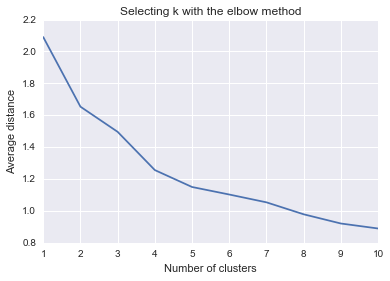

In [16]:
plt.plot(range(1,11), mean_dist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the elbow method')

I think the 'bend' point at which adding more clusters is meaningless is around 4 clusters.

<i>Interpreting the 4 cluster model</i>

In [17]:
model = KMeans(n_clusters = 4)
model.fit(clus_train)
clus_assign = model.predict(clus_train)

<i>Plot the clusters on the first two cononical variables</i>

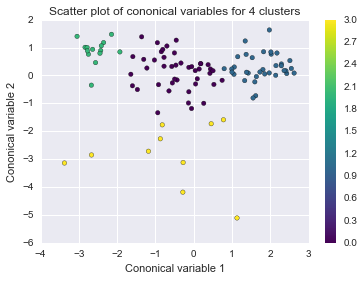

In [18]:
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x = plot_columns[:,0], y = plot_columns[:,1]
           , c = model.labels_, cmap = 'viridis')
plt.xlabel('Cononical variable 1')
plt.ylabel('Cononical variable 2')
plt.title('Scatter plot of cononical variables for 4 clusters')
plt.colorbar()

<i>Link the cluster assignment variable back to its corresponding observation</i>

In [19]:
clus_train.reset_index(inplace = True)

So now the column 'country' is to act as our index

In [20]:
new_frame = pd.DataFrame(model.labels_, columns = ['cluster'])
new_frame.index = clus_train.country

Look at the data frame to see the unique identifier 'country' against the assigned cluster

In [21]:
new_frame.T

country,Germany,Lithuania,Iraq,Nicaragua,Mauritius,El Salvador,Japan,Ghana,Mauritania,Czech Rep.,Botswana,Gabon,Haiti,Guinea-Bissau,Uzbekistan,Uganda,Ireland,Singapore,Panama,Oman,"Macedonia, FYR","Congo, Rep.",Azerbaijan,Argentina,Tajikistan,Dominican Rep.,Eritrea,Senegal,Rwanda,Guatemala,Peru,Nepal,Qatar,Croatia,United Kingdom,Iran,Fiji,Paraguay,Syria,Costa Rica,Saudi Arabia,Venezuela,Tunisia,Hungary,Burundi,Malawi,Slovak Republic,Israel,Ecuador,Niger,India,Chad,Albania,Portugal,Tanzania,Mexico,Sudan,Latvia,Lebanon,Sierra Leone,Cyprus,Sweden,Netherlands,Namibia,Belgium,Laos,Ethiopia,Algeria,Morocco,Greece,New Zealand,Benin,Australia,Ukraine,Georgia,Colombia,Central African Rep.,Cambodia,Nigeria,Equatorial Guinea,Romania,Canada,Cuba,"Korea, Rep.",Burkina Faso,Togo,Indonesia,"Congo, Dem. Rep.",France,Libya,Egypt,Uruguay,Cameroon,Timor-Leste,Philippines,Honduras,Guinea,Zambia,Zimbabwe,Jamaica,Denmark,Thailand
cluster,2,0,3,0,0,0,2,1,1,0,1,0,1,1,1,1,2,3,0,3,0,1,0,0,1,0,3,1,1,0,0,1,2,0,2,0,0,0,3,0,0,0,0,0,1,1,0,3,0,1,1,1,0,0,1,0,1,0,3,1,0,2,2,1,2,3,1,0,0,0,2,1,2,0,0,0,1,1,1,1,0,2,0,2,1,1,0,1,2,3,3,0,1,1,0,0,1,1,1,0,2,0


<i>Merge the cluster assignment into the training data set</i>

In [22]:
clus_data = pd.concat([new_frame, clus_train.set_index('country')], axis = 1)
clus_data.index.name = None
clus_data.head()

,cluster,incomeperperson,alcconsumption,armedforcesrate,co2emissions,lifeexpectancy,urbanrate
Germany,2,1.86,1.02,-0.53,1.16,1.15,0.79
Lithuania,0,-0.15,1.83,0.06,-0.22,0.32,0.48
Iraq,3,-0.62,-1.26,4.11,-0.14,-0.00,0.47
Nicaragua,0,-0.59,-0.34,-0.56,-0.22,0.50,0.02
Mauritius,0,-0.17,-0.66,-0.68,-0.22,0.44,-0.63


<i>Look into how the cluster groups are distrobuted</i>

In [23]:
clus_data.cluster.value_counts()

0    43
1    35
2    14
3    10
Name: cluster, dtype: int64

<i>The means of each explanetory variable by cluster assignment</i>

In [24]:
clus_data.groupby('cluster').mean()

,incomeperperson,alcconsumption,armedforcesrate,co2emissions,lifeexpectancy,urbanrate
cluster,,,,,,
0,-0.23,0.21,-0.09,-0.15,0.50,0.36
1,-0.61,-0.38,-0.49,-0.19,-1.26,-1.03
2,2.00,0.78,-0.38,0.43,1.18,1.18
3,0.17,-1.00,2.76,-0.18,0.40,0.36


<i>Validate the clusters from the training data by examining differences in polityscore using ANOVA</i>

In [25]:
sub_data = pd.concat([gap_data.loc[:,'polityscore'], clus_data], axis = 1).dropna().loc[:,['polityscore','cluster']]

In [26]:
polityscore_mod = smf.ols(formula = 'polityscore ~ C(cluster)', data = sub_data).fit()
polityscore_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            polityscore   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     10.06
Date:                Sun, 22 Jan 2017   Prob (F-statistic):           7.71e-06
Time:                        19:24:26   Log-Likelihood:                -317.22
No. Observations:                 102   AIC:                             642.4
Df Residuals:                      98   BIC:                             652.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             5.4651      0.844      6.475      0.000         3.790     7.140
C(cluster)[T.1.0]    -3.7223      1.260     -2.954      0.004        -6.223    -1.222
C(cluster)[T.2.0]     2.7492      1.703      1.614      0.110        -0.631     6.129
C(cluster)[T.3.0]    -7.8651      1.943     -4.048      0.000       -11.721    -4.009
==============================================================================
Omnibus:                       18.285   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.660
Skew:                          -1.017   Prob(JB):                     1.98e-05
Kurtosis:                       3.979   Cond. No.                         4.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<i>Looking at the means by polityscore</i>

In [36]:
means = sub_data.groupby('cluster').mean()
means.T

cluster,0.0,1.0,2.0,3.0
polityscore,5.47,1.74,8.21,-2.40


<i>Looking at standard deviations by polityscore</i>

In [28]:
stds = sub_data.groupby('cluster').std()
stds.T

cluster,0.0,1.0,2.0,3.0
polityscore,5.91,4.88,5.29,6.36


In [32]:
multicomparison = multi.MultiComparison(sub_data['polityscore'], sub_data['cluster'])
results = multicomparison.tukeyhsd()
results.summary()

group1,group2,meandiff,lower,upper,reject
0.0,1.0,-3.7223,-7.0157,-0.4288,True
0.0,2.0,2.7492,-1.7024,7.2007,False
0.0,3.0,-7.8651,-12.9441,-2.7861,True
1.0,2.0,6.4714,1.8966,11.0463,True
1.0,3.0,-4.1429,-9.3302,1.0445,False
2.0,3.0,-10.6143,-16.6041,-4.6244,True


<i>Means and standard deviation by cluster group, not including polityscore</i>

In [39]:
clus_data.groupby('cluster').mean()

,incomeperperson,alcconsumption,armedforcesrate,co2emissions,lifeexpectancy,urbanrate
cluster,,,,,,
0,-0.23,0.21,-0.09,-0.15,0.50,0.36
1,-0.61,-0.38,-0.49,-0.19,-1.26,-1.03
2,2.00,0.78,-0.38,0.43,1.18,1.18
3,0.17,-1.00,2.76,-0.18,0.40,0.36


In [40]:
clus_data.groupby('cluster').std()

,incomeperperson,alcconsumption,armedforcesrate,co2emissions,lifeexpectancy,urbanrate
cluster,,,,,,
0,0.35,0.95,0.44,0.10,0.34,0.60
1,0.16,0.75,0.35,0.17,0.63,0.60
2,0.65,0.77,0.43,0.72,0.13,0.46
3,1.10,0.39,1.31,0.04,0.61,1.21


<h2>Assignment - Written Analysis</h2>

To find potential underlying subgroups of countries based on 6 characteristics such as incomeperperson and co2emissions that are characteristics which may have an impact on government type. All the clustering variables were standardaised to have a mean of 0 and a standard deviation of 1 so that the are comparable in a meaningful manner.

The data was randomly split into roughly 70% training and 30% test set data. I performed a series of k-means cluster analyses on the training set using k = 1 - 10 clusers, interpreting with euclidean distance. The graph you see in the <b>Out[16]</b> section represents the change in average distence of clusters and the number of clusters. Around 4 - 6 clusters there doesn't seem to be much improvement in the average distance of the clusters against an increase in the number of clusters. I chose 4 clusters as being a sensible number to go forward with.

Cononical discriminant analyses was used to reduce our 6 clustering variables down to the 2 most associated ones so that we can interpret it easily on a 2 dimensional graph. The scatter plot in <b>Out[18]</b> shows the 4 clusters. The most densely distrobuted cluster is cluster 2 which is on the same y-axis level as clusters 0 and 1, clusters 0 and 1 are less densely packed together. The final cluster, 3, is very widely distrobuted but sits defintely below the other clusters relative to the y-axis. So:
<ul>
    <li>Cluster 0 has a reasonable spread of values</li>
    <li>Cluster 1 has a similar spread to cluster 0</li>
    <li>Cluster 2 is very tighly packed, suggesting a very low variance within the cluster</li>
    <li>Cluster 3 has a very wide spread indicating a high variance within the cluster</li>
</ul>

All the clusters are distinct, there is no overlap with other clusters. It also looks like a sensible number of clusters have been identified so 4 may be optimal in this case.

The means and standard deviations of the cluster data set indicate that:
<ul>
    <li><div><u>Cluster 0</u> has means which sit mostly in the middle of the pack and values that have variance less than 1. With a low income per person and levels of co2 emissions it has mostly average values for the other variables. The cluster has a mean polityscore of 5.5 so is relatively high up in the democratic scale.</div></li>
    <li><div><u>Cluster 1</u> has consistently lower means than the other clusters and values with variance less than 1. It has the lowest mean values in everything but alcohol consumption which is still on the lower end of the scale. It has a mean polityscore of 1.7 indicating a fairly neutral score, a not especially democratic goevernment, but not a noteably un-democratic government.</div></li>
    <li><u>Cluster 2</u> has consistently higher means than the other clusters with quite large standard deviation except in lifeexpectancy. It has a mean polityscore of 8.2 which is the highest out of our clusters and very near the top of the scale.</li>
    <li><u>Cluster 3</u> varies quite considerably with its means, being very low on alcohol consumption but exceptionally high with armed forces rate, the rest of the means seem to be average for the data, but the variance is very high for the income per person, armed forces rate and urban rate variables, while quite low for the others. It has a mean polityscore of -2.4 indicating un-democratic governments are typically in control.</li>
</ul>

From the above the most troubled countries would be in cluster 3, while clusters 0 and 2 are well off countries, and cluster 1 is a collection of transitional countries government wise.

To validate the clusters an ANOVA (Analysis of Variance) analysis was performed to test for significant differences between clusters based on polityscore, a tukey post hoc test compared between the clusters. The analysis indicated that there was a significant association between polityscore and cluster with a p-value of 7.71e-06 which is highly significant. There is also a significant difference between the pairs of clusters (0, 2) and (1, 3) which was identified with the tukey post hoc tests, this might indicate that there are only two distinct clusters. Countries in cluster 2 (mean = 8.21, std = 5.29) had vastly higher polityscore than the other clusters while cluster 3 (mean = -2.40, std = 6.36) has a vastly lower polityscore.